<a href="https://colab.research.google.com/github/Raiden-Makoto/Raiden-Makoto/blob/main/NYC_Taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.colab import userdata
project = userdata.get('PROJ_NAME')

In [3]:
from google.cloud import bigquery
# Replace 'your-gcp-project-id' with your actual Google Cloud Project ID.
# You can find your project ID in the Google Cloud Console.
# Explicitly set the location to 'US' to access the public dataset.
client = bigquery.Client(project=project, location='US')

In [4]:
import pandas as pd

Total Number of Taxi Trips from 2013 to 2021

In [5]:
query = """
SELECT
  CAST(_TABLE_SUFFIX AS INT64) AS trip_year,
  COUNT(*) AS trip_count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_*`
WHERE _TABLE_SUFFIX BETWEEN '2013' AND '2021'
GROUP BY trip_year
ORDER BY trip_year;
"""

df = client.query(query).to_dataframe()
df.head(10)

,trip_year,trip_count
0,2013,185787446
1,2014,275921951
2,2015,146039220
3,2016,131131794
4,2017,113500316
5,2018,102871376
6,2019,84598433
7,2020,24649081
8,2021,30904297


In [6]:
print("Total taxi trips from 2013 to 2021", df['trip_count'].sum())

Total taxi trips from 2013 to 2021 1095403914


Now we are interested in calculating the average price and distance of the trips per year

In [7]:
query = """
SELECT
    CAST(_TABLE_SUFFIX AS INT64) AS trip_year,
    ROUND(AVG(trip_distance), 4) AS avg_distance,
    ROUND(AVG(total_amount), 4) AS avg_price
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_*`
WHERE _TABLE_SUFFIX BETWEEN '2013' AND '2021'
    AND trip_distance > 0
    AND fare_amount > 0
GROUP BY trip_year
ORDER BY trip_year;
"""

df = client.query(query).to_dataframe()
df.head(10)

,trip_year,avg_distance,avg_price
0,2013,7.961100000,14.739300000
1,2014,13.208400000,15.372700000
2,2015,12.479900000,16.036900000
3,2016,4.630200000,16.285500000
4,2017,2.948200000,16.267500000
5,2018,2.960400000,16.354300000
6,2019,3.048400000,19.106600000
7,2020,3.580100000,18.343700000
8,2021,7.012600000,19.754800000


We can make a simple line chart for this, why not

In [8]:
import matplotlib.pyplot as plt
import numpy as np

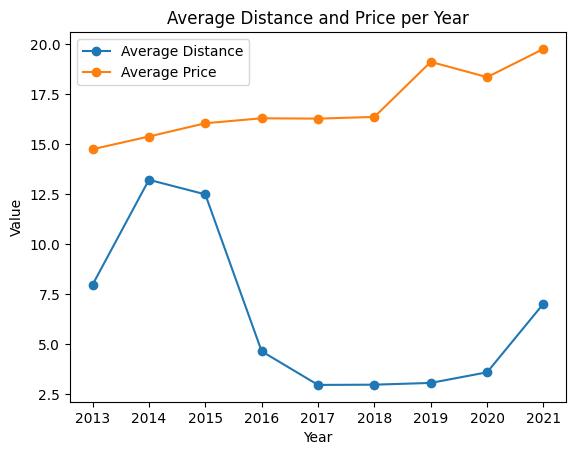

In [9]:
plt.plot(df['trip_year'], df['avg_distance'], label='Average Distance', marker='o')
plt.plot(df['trip_year'], df['avg_price'], label='Average Price', marker='o')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Average Distance and Price per Year')
plt.legend()
plt.show()

We are now interested in the peak hours of taxi use

In [10]:
query = """
SELECT
    CAST(_TABLE_SUFFIX AS INT64) AS trip_year,
    EXTRACT(HOUR FROM pickup_datetime) AS trip_hour,
    COUNT(*) as trip_count

FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_*`
WHERE _TABLE_SUFFIX BETWEEN '2013' AND '2021'
GROUP BY trip_year, trip_hour
ORDER BY trip_year, trip_hour;
"""

df = client.query(query).to_dataframe()
df.head(10)

,trip_year,trip_hour,trip_count
0,2013,0,7443045
1,2013,1,5503519
2,2013,2,4074801
3,2013,3,2973949
4,2013,4,2176593
5,2013,5,1861613
6,2013,6,3833524
7,2013,7,6709077
8,2013,8,8310451
9,2013,9,8627601


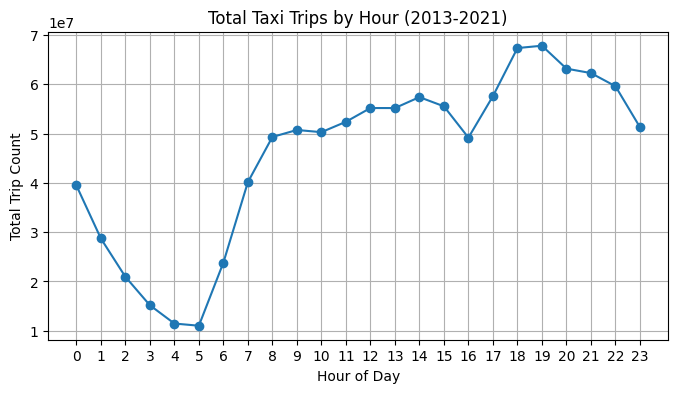

In [11]:
trips_by_hour = df.groupby('trip_hour')['trip_count'].sum().reset_index()

plt.figure(figsize=(8, 4))
plt.plot(trips_by_hour['trip_hour'], trips_by_hour['trip_count'], marker='o', linestyle='-')
plt.xlabel('Hour of Day')
plt.ylabel('Total Trip Count')
plt.title('Total Taxi Trips by Hour (2013-2021)')
plt.xticks(range(0, 24)) # Ensure all hours are displayed
plt.grid(True)
plt.show()

From this plot, we can see that the peak hours of taxi usage are in the evening from 6-7 pm. We also see that the hours of the least taxi usage are from 4-5am.

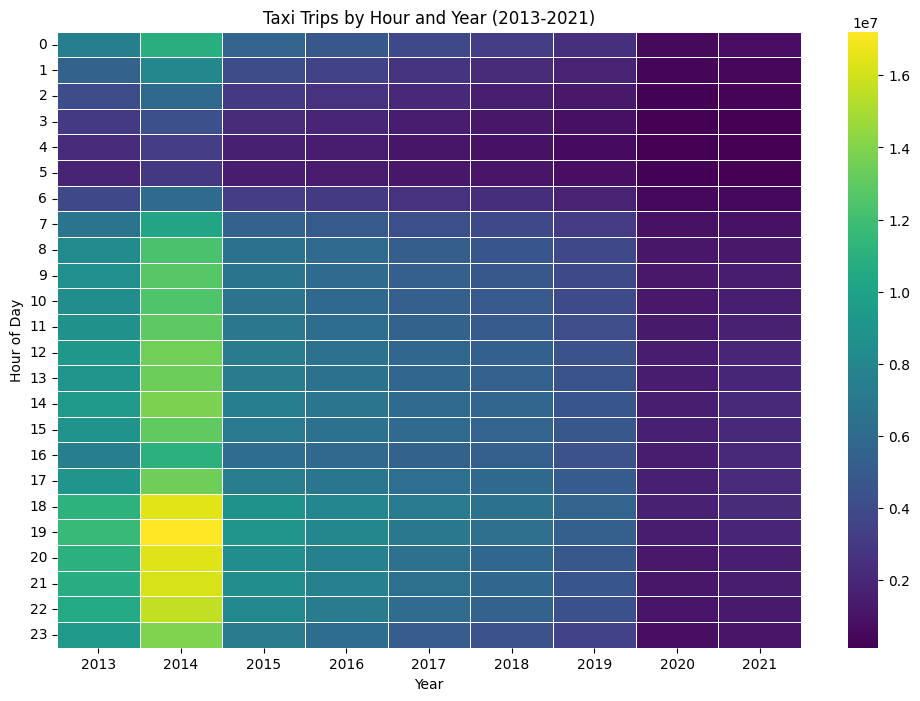

In [12]:
import seaborn as sns

trips_pivot = df.pivot_table(index='trip_hour', columns='trip_year', values='trip_count')

# Fill NaN values with 0 and then explicitly convert to float to ensure all data is numeric
trips_pivot = trips_pivot.fillna(0).astype(float)

plt.figure(figsize=(12, 8))
sns.heatmap(trips_pivot, cmap='viridis', fmt='g', linewidths=.5)
plt.title('Taxi Trips by Hour and Year (2013-2021)')
plt.xlabel('Year')
plt.ylabel('Hour of Day')
plt.yticks(rotation=0)
plt.show()

Now lets analyze the financial aspects

In [13]:
query = """
SELECT
    CAST(_TABLE_SUFFIX AS INT64) AS trip_year,
    CASE
        WHEN CAST(payment_type AS INT64) = 1 THEN 'Credit Card'
        WHEN CAST(payment_type AS INT64) = 2 THEN 'Cash'
        ELSE 'Other'
    END AS payment_method,
    SUM(total_amount) AS total_revenue
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_*`
WHERE _TABLE_SUFFIX BETWEEN '2013' AND '2021'
GROUP BY trip_year, payment_method
ORDER BY trip_year, payment_method DESC;
"""
df = client.query(query).to_dataframe()
df.head()

,trip_year,payment_method,total_revenue
0,2013,Other,12018117.470000000
1,2013,Credit Card,1690125489.850000000
2,2013,Cash,1048860039.350000000
3,2014,Other,24820442.350000000
4,2014,Credit Card,2760818378.430000000


/tmp/ipython-input-1395933723.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  revenue_pivot = df.pivot_table(index='trip_year', columns='payment_method', values='total_revenue', fill_value=0)


<Figure size 800x500 with 0 Axes>

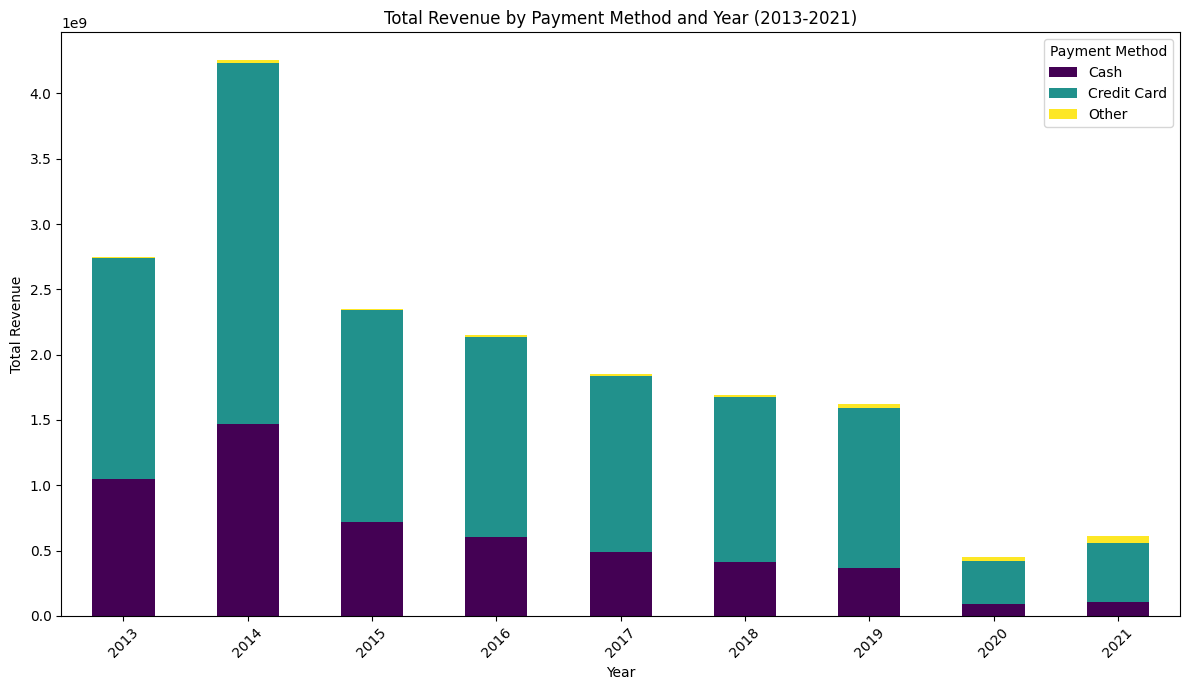

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot the DataFrame to get years as index, payment methods as columns, and total_revenue as values
revenue_pivot = df.pivot_table(index='trip_year', columns='payment_method', values='total_revenue', fill_value=0)

# Plotting the stacked bar chart
plt.figure(figsize=(8, 5))
revenue_pivot.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 7))

plt.title('Total Revenue by Payment Method and Year (2013-2021)')
plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.legend(title='Payment Method')
plt.tight_layout()
plt.show()

Finally, we want to see the busiest and least busy pickup locations.

In [15]:
query = """
WITH location_counts AS (
  SELECT
      CAST(_TABLE_SUFFIX AS INT64) AS trip_year,
      pickup_location_id,
      COUNT(*) AS trip_count
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_*`
  WHERE _TABLE_SUFFIX BETWEEN '2013' AND '2021'
  GROUP BY trip_year, pickup_location_id
)
, ranked_locations AS (
  SELECT
      trip_year,
      pickup_location_id,
      trip_count,
      ROW_NUMBER() OVER (
        PARTITION BY trip_year
        ORDER BY trip_count DESC
      ) AS rank
  FROM location_counts
)
SELECT
    r.trip_year,
    r.pickup_location_id,
    z.zone_name AS pickup_location_name,
    z.borough,
    r.trip_count
FROM ranked_locations r
JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` z
ON CAST(r.pickup_location_id AS STRING) = z.zone_id
WHERE r.rank <= 10
ORDER BY r.trip_year, r.trip_count DESC

"""
df = client.query(query).to_dataframe()
df.head(10)

,trip_year,pickup_location_id,pickup_location_name,borough,trip_count
0,2013,237,Upper East Side South,Manhattan,6693726
1,2013,161,Midtown Center,Manhattan,6268745
2,2013,79,East Village,Manhattan,6152994
3,2013,162,Midtown East,Manhattan,6125180
4,2013,234,Union Sq,Manhattan,6054672
5,2013,170,Murray Hill,Manhattan,6047684
6,2013,230,Times Sq/Theatre District,Manhattan,5977486
7,2013,236,Upper East Side North,Manhattan,5969443
8,2013,48,Clinton East,Manhattan,5890281
9,2013,186,Penn Station/Madison Sq West,Manhattan,5468732


In [16]:
query = """
WITH location_counts AS (
  SELECT
      CAST(_TABLE_SUFFIX AS INT64) AS trip_year,
      pickup_location_id,
      COUNT(*) AS trip_count
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_*`
  WHERE _TABLE_SUFFIX BETWEEN '2013' AND '2021'
  GROUP BY trip_year, pickup_location_id
)
, ranked_locations AS (
  SELECT
      trip_year,
      pickup_location_id,
      trip_count,
      ROW_NUMBER() OVER (
        PARTITION BY trip_year
        ORDER BY trip_count ASC
      ) AS rank
  FROM location_counts
)
SELECT DISTINCT
    r.trip_year,
    r.pickup_location_id,
    z.zone_name AS pickup_location_name,
    z.borough,
    r.trip_count
FROM ranked_locations r
JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` z
ON CAST(r.pickup_location_id AS STRING) = z.zone_id
WHERE r.rank <= 10
ORDER BY r.trip_year, r.trip_count
"""
df = client.query(query).to_dataframe()
df.head(10)

,trip_year,pickup_location_id,pickup_location_name,borough,trip_count
0,2013,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,4
1,2013,176,Oakwood,Staten Island,34
2,2013,204,Rossville/Woodrow,Staten Island,38
3,2013,30,Broad Channel,Queens,51
4,2013,187,Port Richmond,Staten Island,76
5,2013,44,Charleston/Tottenville,Staten Island,78
6,2013,109,Great Kills,Staten Island,85
7,2013,110,Great Kills Park,Staten Island,91
8,2013,59,Crotona Park,Bronx,98
9,2014,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,8


Now, what about the most traveled routes?

In [17]:
query = """
SELECT
  trips.pickup_location_id,
  pickup.zone_name AS pickup_name,
  trips.dropoff_location_id,
  dropoff.zone_name AS dropoff_name,
  COUNT(*) AS trip_count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_*` AS trips
JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` AS pickup
  ON CAST(trips.pickup_location_id AS STRING) = pickup.zone_id
JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` AS dropoff
  ON CAST(trips.dropoff_location_id AS STRING) = dropoff.zone_id
WHERE _TABLE_SUFFIX BETWEEN '2013' AND '2021'
GROUP BY
  trips.pickup_location_id,
  pickup.zone_name,
  trips.dropoff_location_id,
  dropoff.zone_name
ORDER BY
  trip_count DESC
LIMIT 10
"""
df = client.query(query).to_dataframe()
df.head()

,pickup_location_id,pickup_name,dropoff_location_id,dropoff_name,trip_count
0,237,Upper East Side South,236,Upper East Side North,5475053
1,236,Upper East Side North,237,Upper East Side South,4739035
2,236,Upper East Side North,236,Upper East Side North,4538754
3,237,Upper East Side South,237,Upper East Side South,4389330
4,237,Upper East Side South,162,Midtown East,2607900


In [18]:
import pandas as pd

# Create nodes_df
pickup_nodes = df[['pickup_location_id', 'pickup_name']].rename(columns={'pickup_location_id': 'id', 'pickup_name': 'name'})
dropoff_nodes = df[['dropoff_location_id', 'dropoff_name']].rename(columns={'dropoff_location_id': 'id', 'dropoff_name': 'name'})
nodes_df = pd.concat([pickup_nodes, dropoff_nodes]).drop_duplicates().reset_index(drop=True)

# Create edges_df
edges_df = df.rename(columns={
    'pickup_location_id': 'source',
    'dropoff_location_id': 'target',
    'trip_count': 'weight'
})[['source', 'target', 'weight']]

print("Nodes DataFrame head:")
print(nodes_df.head())
print("\nEdges DataFrame head:")
print(edges_df.head())

Nodes DataFrame head:
    id                   name
0  237  Upper East Side South
1  236  Upper East Side North
2  239  Upper West Side South
3  142    Lincoln Square East
4  238  Upper West Side North

Edges DataFrame head:
  source target   weight
0    237    236  5475053
1    236    237  4739035
2    236    236  4538754
3    237    237  4389330
4    237    162  2607900


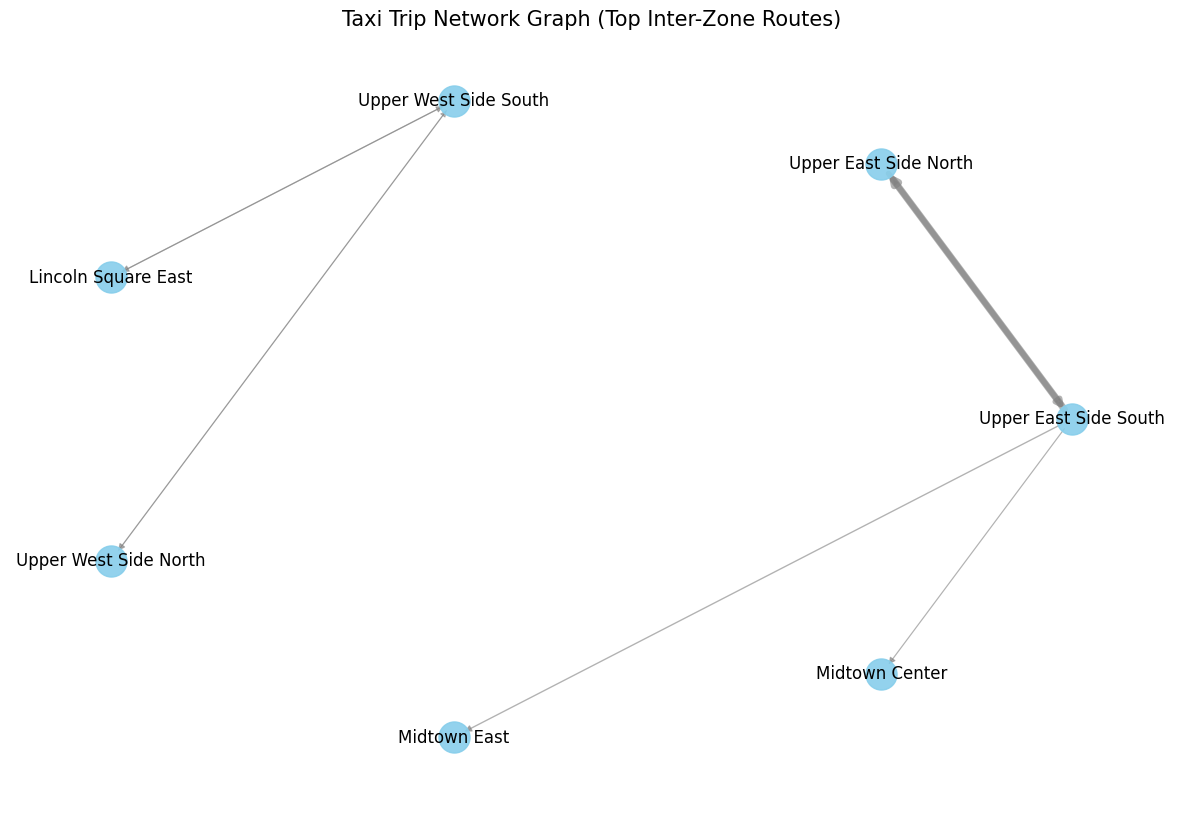

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Remove self-loops
edges_to_draw = [(row['source'], row['target'], row['weight'])
                 for _, row in edges_df.iterrows() if row['source'] != row['target']]

G = nx.DiGraph()
for node_id, name in zip(nodes_df['id'], nodes_df['name']):
    G.add_node(node_id, name=name)

for source, target, weight in edges_to_draw:
    G.add_edge(source, target, weight=weight)

edge_weights = [d['weight'] for (_, _, d) in G.edges(data=True)]
max_weight, min_weight = max(edge_weights), min(edge_weights)
scaled_edge_weights = [0.5 + (w - min_weight) / (max_weight - min_weight) * 4.5 for w in edge_weights]

pos = nx.circular_layout(G)
plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=scaled_edge_weights, alpha=0.6, edge_color='gray')
node_labels = {node_id: G.nodes[node_id]['name'] for node_id in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
plt.title('Taxi Trip Network Graph (Top Inter-Zone Routes)', size=15)
plt.axis('off')
plt.show()
